# Set up environment

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import os
import matplotlib.pyplot as plt
import numpy as np
import copy
import shutil
from PIL import Image
from tqdm.autonotebook import tqdm
import sys
import xml.etree.cElementTree as ET

## Import utility functions from Pytorch

In [2]:
ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))

sys.path.append(os.path.join(ROOT_DIR, "utilities"))

from engine import train_one_epoch, evaluate
import utils

## Enable GPU

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

Running on cuda:0


## Declare parameters

In [4]:
IMAGE_SIZE = 512
BATCH_SIZE = 4

# Input data

## Download Food256 dataset

To extend the food classification into food detection I will need a dataset that includes bounding boxes, thus I have used food-256 including 256 different classes that contain atleast 100 images each. If the given directory not found then dataset is downloaded and extracted.

In [5]:
FOOD256_DIR = os.path.join(os.path.abspath(os.sep), "Datasets", "food256")

if not os.path.exists(FOOD256_DIR):
  print("Downloading Food-256 dataset... ", end="")
  !wget http://foodcam.mobi/dataset256.zip
  print("Done")


  print("Extracting data... ", end="")
  !unzip dataset256.zip
  print("Done")

## Format dataset in VOC Format

Please refer to format_voc notebook in utilities directory.

## Define FoodDataset class

In the condensed version we read a list of condensed classes in the current working directory and only include images containing such catergories.

In [6]:
class FoodDataset(torch.utils.data.Dataset):
    def __init__(self, root, images, transform=None):
        self.root = root
        self.transform = transform
        self.classes = self.getClasses()
        self.images = self.condense(images)
            
            
    def getClasses(self):
        classes = []
        with open("condensed_category.txt", 'r') as file:
            file.readline()
            for line in file.readlines():
                classes.append(line.strip().split("\t")[1])
        return classes
            
        
    def condense(self, images):
        condensed = []
        
        for img in images:
            # open annotations file
            tree = ET.parse(os.path.join(self.root, "Annotations", img.replace('.jpg', '.xml')))
            root = tree.getroot()
                            
            # add to condensed only if contains class in condensed classed
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                if class_name in self.classes:
                    condensed.append(img)
                    break
                            
        return condensed
            
                
    def getLabels(self, img_id):
        # open annotations file
        tree = ET.parse(os.path.join(self.root, "Annotations", img_id+'.xml'))
        root = tree.getroot()
        
        # read bounding boxes
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            
            if class_name in self.classes:
                return self.classes.index(class_name)
        
    def __getitem__(self, index):
        # image
        img_path = os.path.join(self.root, "JPEGImages", self.images[index])
        img = Image.open(img_path).convert("RGB")
        
        # annotations
        lbl = self.getLabels(self.images[index].split('.')[0])
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, lbl
        
    
    def __len__(self):
        return len(self.images)

## Format images for model input

In [7]:
# custom transform for R-CNN input
class CustomTransform:
    def __init__(self, image_size):
        self.image_size = image_size
        
    def __call__(self, img):
        # resize to a max of IMAGE_SIZE
        w, h = img.size
        scale = min(IMAGE_SIZE/w, IMAGE_SIZE/h)
        img = transforms.functional.resize(img, (int(h*scale), int(w*scale)))
        
        # add padding to a size of IMAGE_SIZE
        img = transforms.functional.pad(img, (0, 0, IMAGE_SIZE-int(w*scale), IMAGE_SIZE-int(h*scale)))
        
        # convert to tensor
        img = transforms.functional.to_tensor(img)

        # normalize
        img = transforms.functional.normalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        return img

transform = CustomTransform(image_size=IMAGE_SIZE)

## Read training and validations splits

In [8]:
SPLIT_DIR = os.path.join(FOOD256_DIR, "ImageSets", "Main")

with open(os.path.join(SPLIT_DIR, "train.txt"), 'r') as file:
    images = [x.strip() for x in file.readlines()]
    train_raw = FoodDataset(FOOD256_DIR, images, transform=transform)
    
with open(os.path.join(SPLIT_DIR, "val.txt"), 'r') as file:
    images = [x.strip() for x in file.readlines()]
    val_raw = FoodDataset(FOOD256_DIR, images, transform=transform)

train_size = len(train_raw)
val_size = len(val_raw)

class_names = train_raw.classes

print("Number of training images: {0}".format(train_size))
print("Number of validation images: {0}".format(val_size))

Number of training images: 8361
Number of validation images: 932


## Batch datasets for training and evaluation

In [9]:
train_loader = torch.utils.data.DataLoader(train_raw, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_raw, batch_size=BATCH_SIZE, shuffle=True)

## Show example training image with bounding boxes

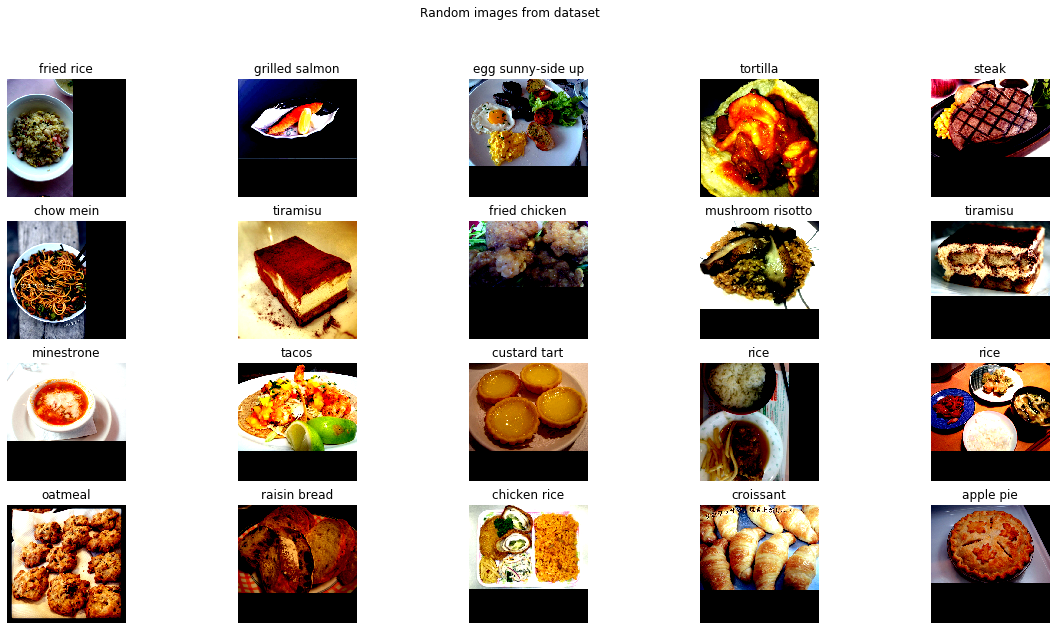

In [10]:
cols, rows = 5, 4
fig = plt.figure(figsize=(20,10))
fig.suptitle("Random images from dataset")

for i in range(1, cols*rows+1):
  fig.add_subplot(rows, cols, i)

  # randomly sellect image from dataset
  j = np.random.randint(train_size)
  img = train_raw[j][0].numpy()
  img = np.transpose(img, (1,2,0))
  img = img * (0.485, 0.456, 0.406) + (0.229, 0.224, 0.225)

  plt.title(class_names[train_raw[j][1]])
  plt.axis("off")
  img = np.clip(img, 0, 1)
  plt.imshow(img, interpolation="nearest")
fig

# Model

## Declare backbone model architecture

Currently supports:
    - mobilenet_v2
    - wide_resnet_101

In [11]:
MODEL_NAME = "mobilenet_v2"

## Fetch pretrainied backbone

In order to train the food classifier I will initially use fine tuning from a pretrained model. This involves replacing the classification head with a 75-way dense layer and freezing all other layers.

In [12]:
print("Fetching pretrained model... ", end="")

# fetch pre-trained feature extractor
if MODEL_NAME == "mobilenet_v2":
    model = torchvision.models.mobilenet_v2(pretrained=True)
elif MODEL_NAME == "wide_resnet_101":
    model = torchvision.models.wide_resnet101_2(pretrained=True)

# replace classification head
if MODEL_NAME == "mobilenet_v2":
    num_features = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(num_features, len(class_names))
    
elif MODEL_NAME == "wide_resnet_101":
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, len(class_names))

model = model.to(device)
print("done")

Fetching pretrained model... done


## Load checkpoint if weights file exists

In [13]:
MODEL_PATH = os.path.join(ROOT_DIR, "models", "condensed_food_detection", "backbones", MODEL_NAME, "fine_tuning.pt")

if os.path.exists(MODEL_PATH):
    print("Loading weights from checkpoint...", end="")
    model.load_state_dict(torch.load(MODEL_PATH))
    print("done")

# Train via fine-tuning

## Declare training parameters

In [19]:
learning_rate = 0.001
epochs = 2

# fetch trainable parameters
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=learning_rate)
loss_func = torch.nn.CrossEntropyLoss()

## Main Training Loop

In [20]:
def train(optimzer, loss_func, num_epochs):
  best_acc = 0.0
  best_model_weights = None
  statistics = {
    "accuracy": [],
    "val_accuracy": []
  }

  for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    i = 0
    with tqdm(total=train_size) as progress_bar:
        progress_bar.set_description("Epoch {}/{}".format(epoch, num_epochs))
        for (images, labels) in train_loader:
          images = images.to(device)
          labels = labels.to(device)

          # reset the parameter gradients
          optimizer.zero_grad()

          # fit images on model
          if MODEL_NAME == "inception_v3":
              outputs, aux_outputs = model(images)
              _, predictions = torch.max(outputs, 1)
              loss1 = loss_func(outputs, labels)
              loss2 = loss_func(aux_outputs, labels)
              loss = loss1 + 0.4 * loss2
            
          else:
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            loss = loss_func(outputs, labels)

          loss.backward()
          optimizer.step()

          running_loss += loss.item() * images.size(0)
          running_corrects += torch.sum(predictions == labels.data)

          i += 1
          progress_bar.update(BATCH_SIZE)
          progress_bar.set_postfix(epoch_loss=running_loss/(i*BATCH_SIZE), epoch_acc=running_corrects.double().item()/(i*BATCH_SIZE))
    
    # calculate statistics
    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    
    # print statistics
    print("Training Loss: {:.4f}, Acc: {:.4f}".format(epoch_loss, epoch_acc))
    statistics['accuracy'].append(epoch_acc)
    
    val_loss, val_acc = validate(loss_func)

    # save best model seen
    if val_acc > best_acc:
      best_acc = epoch_acc
      best_model_weights = copy.deepcopy(model.state_dict())

    # print statistics
    print("Validation Loss: {:.4f}, Acc: {:.4f}\n".format(val_loss, val_acc))
    statistics['val_accuracy'].append(val_acc)
    
  # reinstantiate best seen weights
  model.load_state_dict(best_model_weights)

  print("DONE")

  return statistics

## Validation

In [21]:
def validate(loss_func):
  model.eval()
  running_loss = 0.0
  running_corrects = 0

  for (images, labels) in val_loader:
    images = images.to(device)
    labels = labels.to(device)

    # fit images on model
    with torch.no_grad():
      outputs = model(images)
      _, predictions = torch.max(outputs, 1)
      loss = loss_func(outputs, labels)

    running_loss += loss.item() * images.size(0)
    running_corrects += torch.sum(predictions == labels.data)

  # calculate statistics
  val_loss = running_loss / val_size
  val_acc = running_corrects.double() / val_size

  return val_loss, val_acc

## Train and save model

In [ ]:
if epochs > 0:
    statistics = train(optimizer, loss_func, epochs)
    torch.save(model.state_dict(), MODEL_PATH)


Training Loss: 1.2007, Acc: 0.7187
Validation Loss: 1.0904, Acc: 0.7275



# Evaluate Training

In [18]:
if epochs > 0:
    plt.plot(statistics['accuracy'], label='accuracy')
    plt.plot(statistics['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.grid(True)
    plt.legend(loc='lower right')